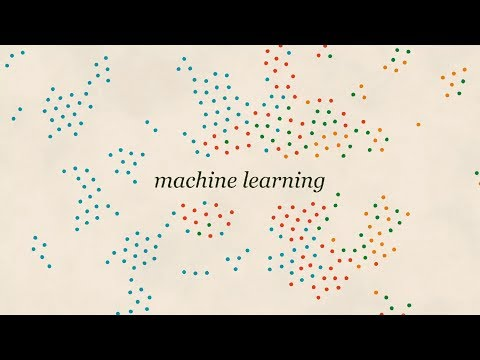

In [1]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

In [3]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [4]:
number_of_training_data = loader.get_train_size()
print(number_of_training_data)

109914


In [5]:
(images, labels) = loader.get_batch(100)

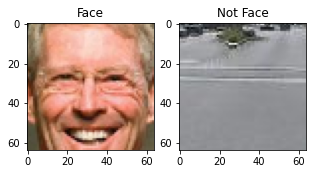

In [6]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 15 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 29 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [7]:
n_filters = 12

def make_standard_classifier(n_ooutputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation="relu")

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3, strides=2),                               
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_ooutputs, activation=None)
  ])
  return model

standard_classifier = make_standard_classifier()

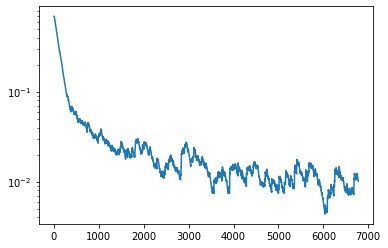

100%|██████████| 3434/3434 [00:44<00:00, 76.59it/s]


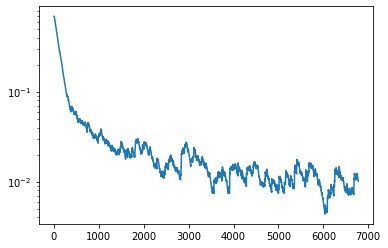

In [8]:
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())


In [9]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9968


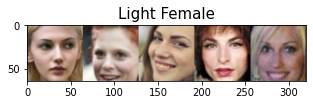

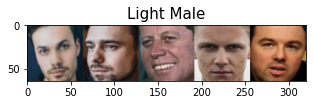

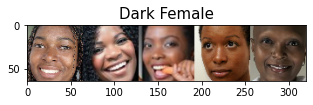

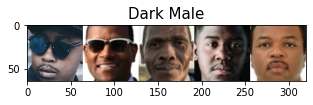

In [10]:
test_faces = mdl.lab2.get_test_faces()
keys=["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces, keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard classifier predictions')

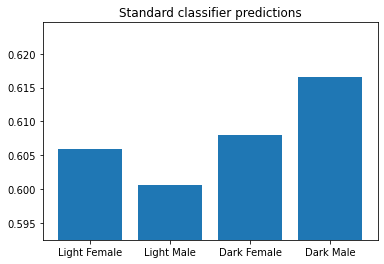

In [33]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)

plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions")

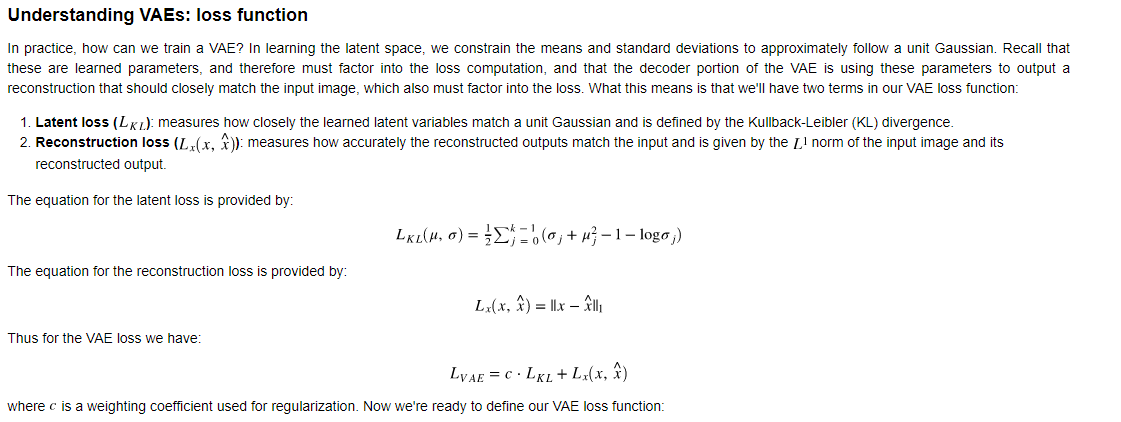

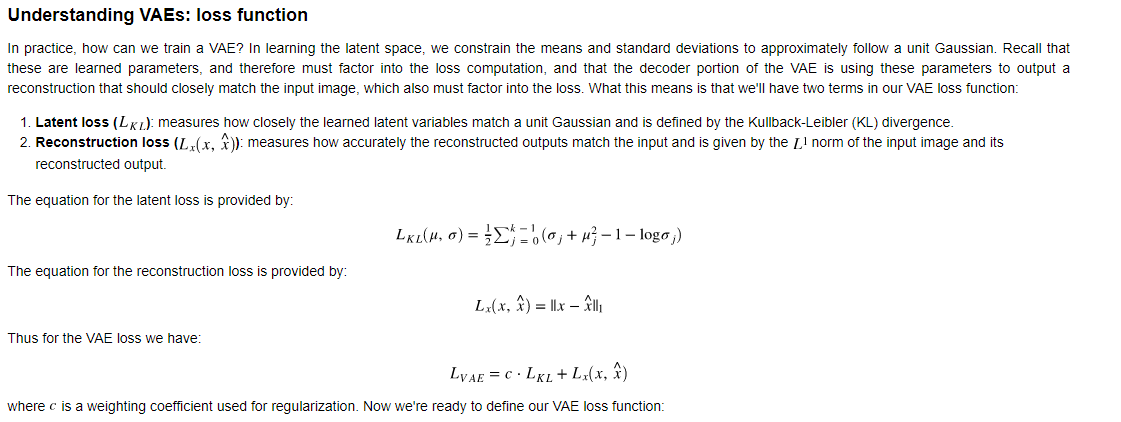

In [12]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5*tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight*latent_loss+reconstruction_loss
  return vae_loss

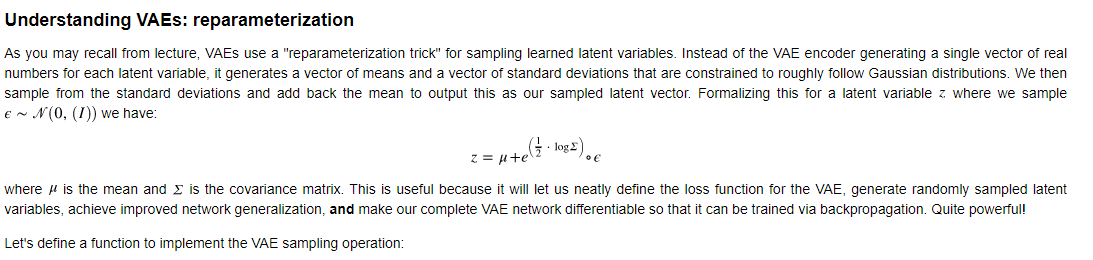

In [13]:
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.math.exp(0.5*z_logsigma)*epsilon
  return z

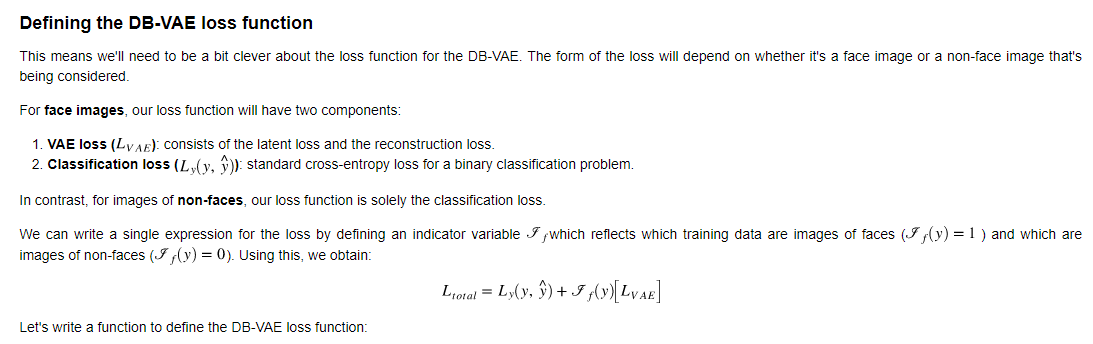

In [24]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, y, y_logit)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  face_indicator = tf.cast(tf.equal(y,1), tf.float32)
  total_loss = tf.reduce_mean(classification_loss + face_indicator*vae_loss)
  return total_loss, classification_loss  

In [25]:
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder


In [26]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [27]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))

  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
    return mu

In [28]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

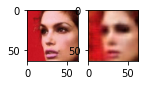

 14%|█▍        | 496/3434 [00:06<00:37, 77.80it/s]

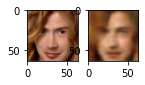

 29%|██▉       | 996/3434 [00:12<00:30, 79.49it/s]

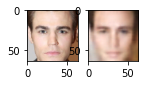

 44%|████▎     | 1496/3434 [00:19<00:23, 81.42it/s]

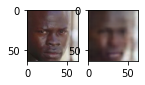

 58%|█████▊    | 1999/3434 [00:25<00:17, 80.49it/s]

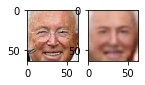

 73%|███████▎  | 2492/3434 [00:32<00:11, 80.27it/s]

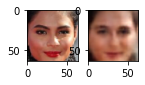

 87%|████████▋ | 2999/3434 [00:38<00:05, 78.22it/s]

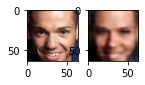

100%|██████████| 3434/3434 [00:44<00:00, 77.44it/s]


In [29]:

### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = debiasing_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

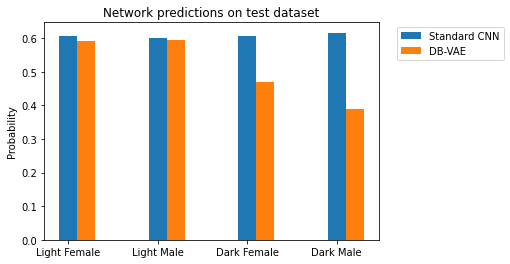

In [32]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");